LSTM Model training 

In [2]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np
from tensorflow.keras import layers, models
import json
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.layers import Embedding, Concatenate, Input
from tensorflow.keras.models import Model




LSTM Definition Function

In [3]:
def create_lstm_model(timesteps, num_features, num_users):
    # Separate input for user_id
    user_input = Input(shape=(1,), name='user_input')
    
    # User embedding layer
    user_embedding = Embedding(
        input_dim=num_users,  # Total number of unique users
        output_dim=min(50, (num_users + 1) // 2),  # Embedding dimension
        input_length=1
    )(user_input)
    
    # Flatten the embedding
    user_embedding_flat = layers.Flatten()(user_embedding)
    
    # Main input for other features
    feature_input = Input(shape=(timesteps, num_features), name='feature_input')
    
    # LSTM layers
    x = LSTM(64, activation='tanh', return_sequences=True)(feature_input)
    x = LSTM(32, activation='tanh', return_sequences=False)(x)
    
    # Concatenate LSTM output with user embedding
    x = Concatenate()([x, user_embedding_flat])
    
    # Dense layers
    x = Dense(16, activation='relu')(x)
    output = Dense(2, activation='linear')(x)
    
    # Create model
    model = Model(inputs=[feature_input, user_input], outputs=output)
    
    model.compile(optimizer='adam', 
                  loss='mean_squared_error', 
                  metrics=['mae'])
    
    return model

class LossHistory(tf.keras.callbacks.Callback):
        def __init__(self):
            super().__init__()
            self.train_losses = []
            self.val_losses = []
        
        def on_epoch_end(self, epoch, logs=None):
            self.train_losses.append(logs.get('loss'))
            self.val_losses.append(logs.get('val_loss'))

            return model, LossHistory()



Hyperparameter tuning

In [ ]:
from keras_tuner import RandomSearch
import tensorflow as tf

def build_model(hp):
    model = Sequential()
    model.add(LSTM(units=hp.Int('units_1', min_value=32, max_value=128, step=32), 
                   activation='tanh', 
                   input_shape=(timesteps, num_features), 
                   return_sequences=True))
    model.add(LSTM(units=hp.Int('units_2', min_value=16, max_value=64, step=16), activation='tanh'))
    model.add(Dense(units=hp.Int('dense_units', min_value=16, max_value=64, step=16), activation='relu'))
    model.add(Dense(2, activation='linear'))
    model.compile(optimizer=tf.keras.optimizers.Adam(
                      learning_rate=hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])),
                  loss='mean_squared_error',
                  metrics=['mae'])
    return model


Cross-Validation 

In [5]:
from sklearn.model_selection import KFold

def perform_cross_validation(x_reshaped, y_reshaped, timesteps, num_features):
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    cv_scores = []
    
    for train_index, val_index in kf.split(x_reshaped):
        x_train_fold, x_val_fold = x_reshaped[train_index], x_reshaped[val_index]
        y_train_fold, y_val_fold = y_reshaped[train_index], y_reshaped[val_index]
        
        model = create_lstm_model(timesteps, num_features)
        
        model.fit(x_train_fold, y_train_fold, epochs=10, batch_size=32, verbose=0)
        
        val_loss = model.evaluate(x_val_fold, y_val_fold, verbose=0)
        cv_scores.append(val_loss[0])
    
    print(f"Cross-Validation Loss Scores: {cv_scores}")
    print(f"Mean CV Loss: {np.mean(cv_scores)}")
    
    return cv_scores

Model Evaluation

In [6]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

def evaluate_model(model, x_test_features, x_test_users, y_test, scaler_y):
    predictions = model.predict([x_test_features, x_test_users])
    
    y_test_original = scaler_y.inverse_transform(y_test)
    predicted_values = scaler_y.inverse_transform(predictions)
    
    mse = mean_squared_error(y_test_original, predicted_values)
    mae = mean_absolute_error(y_test_original, predicted_values)
    r2 = r2_score(y_test_original, predicted_values)
    
    print(f"Mean Squared Error (MSE): {mse}")
    print(f"Mean Absolute Error (MAE): {mae}")
    print(f"R² Score: {r2}")
    
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test_original[:, 0], predicted_values[:, 0], label='Row Predictions', alpha=0.6)
    plt.scatter(y_test_original[:, 1], predicted_values[:, 1], label='Col Predictions', alpha=0.6, color='orange')
    plt.plot([y_test_original.min(), y_test_original.max()], 
             [y_test_original.min(), y_test_original.max()], 
             color='red', linestyle='--', label='Perfect Prediction')
    plt.xlabel('True Values')
    plt.ylabel('Predicted Values')
    plt.title('Prediction Errors Scatter Plot')
    plt.legend()
    plt.show()
    
    return predicted_values



In [7]:
def plot_loss_history(history):
    """
    Plot training and validation loss
    
    Parameters:
    -----------
    history : LossHistory
        Custom callback that tracked losses during training
    """
    plt.figure(figsize=(10, 6))
    plt.plot(history.train_losses, label='Training Loss', color='blue', marker='o')
    plt.plot(history.val_losses, label='Validation Loss', color='red', marker='s')
    
    plt.title('LSTM Model Loss', fontsize=16)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    
    plt.savefig('lstm_loss_plot.png')
    plt.show()

Visualization

In [8]:
import seaborn as sns

def create_regional_heatmap(predicted_values, y_test_original, df):
    predicted_df = pd.DataFrame(predicted_values, columns=['row_pred', 'col_pred'])
    true_df = pd.DataFrame(y_test_original, columns=['row_true', 'col_true'])
    
    predicted_df['region'] = df['region'][:len(predicted_df)]
    region_predictions = predicted_df.groupby('region').mean()
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(region_predictions.pivot_table(values='row_pred', index='region', columns='col_pred'), cmap='coolwarm')
    plt.title('Geographical Heatmap of Network Load Predictions')
    plt.show()

Main Execution Script

In [ ]:
# Main script to tie everything together
def main():    
# Load and preprocess data
    df = pd.read_csv('updated_dataset.csv')

    # Print basic dataset info
    print("Dataset shape:", df.shape)
    print("Columns:", df.columns)
    
    # Extract features and labels
    x_data = df[['lat', 'long', 'user_id', 'time', 'day_of_the_week']].values
    y_data = df[['row', 'col']].values
    
    # Normalize features
    scaler_x = MinMaxScaler()
    x_data = scaler_x.fit_transform(x_data)
    
    scaler_y = MinMaxScaler()
    y_data = scaler_y.fit_transform(y_data)
    
    # Reshape data for LSTM
    timesteps = 10
    num_features = x_data.shape[1]
    x_reshaped = []
    y_reshaped = []
    
    for i in range(len(x_data) - timesteps):
        x_reshaped.append(x_data[i:i + timesteps])
        y_reshaped.append(y_data[i + timesteps])
    
    x_reshaped = np.array(x_reshaped)
    y_reshaped = np.array(y_reshaped)
    
    # Split data
    x_train, x_test, y_train, y_test = train_test_split(x_reshaped, y_reshaped, test_size=0.2, random_state=42)
    
    # Perform hyperparameter tuning
    tuner = RandomSearch(
        build_model,
        objective='val_loss',
        max_trials=10,
        executions_per_trial=1,
        directory='hyperparam_search',
        project_name='traffic_prediction_lstm'
    )
    tuner.search(x_train, y_train, epochs=10, validation_data=(x_test, y_test), batch_size=32)
    
    # Get best hyperparameters
    best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
    print("Best Hyperparameters:", best_hps)
    
    # Perform cross-validation
    cv_scores = perform_cross_validation(x_reshaped, y_reshaped, timesteps, num_features)
    
    # Train final model with best hyperparameters
    # Create model with loss history tracking
    model, loss_history = create_lstm_model(timesteps, num_features, num_users)
    
    # Fit model with both feature and user inputs and loss history callback
    history = model.fit(
        [x_train_features, x_train_users], y_train,
        epochs=50,
        batch_size=32,
        validation_data=([x_test_features, x_test_users], y_test),
        callbacks=[loss_history],  # Add the loss history callback
        verbose=1
    )
    
    # Plot and save loss history
    plot_loss_history(loss_history)
    
    # Evaluate model
    predicted_values = evaluate_model(model, x_test, y_test, scaler_y)
    
    # Create regional heatmap
    create_regional_heatmap(predicted_values, scaler_y.inverse_transform(y_test), df)
    
    # Save the model
    model.save('lstm_traffic_predictor.h5')

if __name__ == '__main__':
    main()
   

Dataset shape: (24876978, 19)
Columns: Index(['lat', 'long', 'zero', 'alt', 'date', 'date_as_string',
       'time_as_string', 'user_id', 'time', 'row', 'col', 'day_of_the_week',
       'day_Friday', 'day_Monday', 'day_Saturday', 'day_Sunday',
       'day_Thursday', 'day_Tuesday', 'day_Wednesday'],
      dtype='object')


MemoryError: Unable to allocate 9.27 GiB for an array with shape (24876968, 10, 5) and data type float64

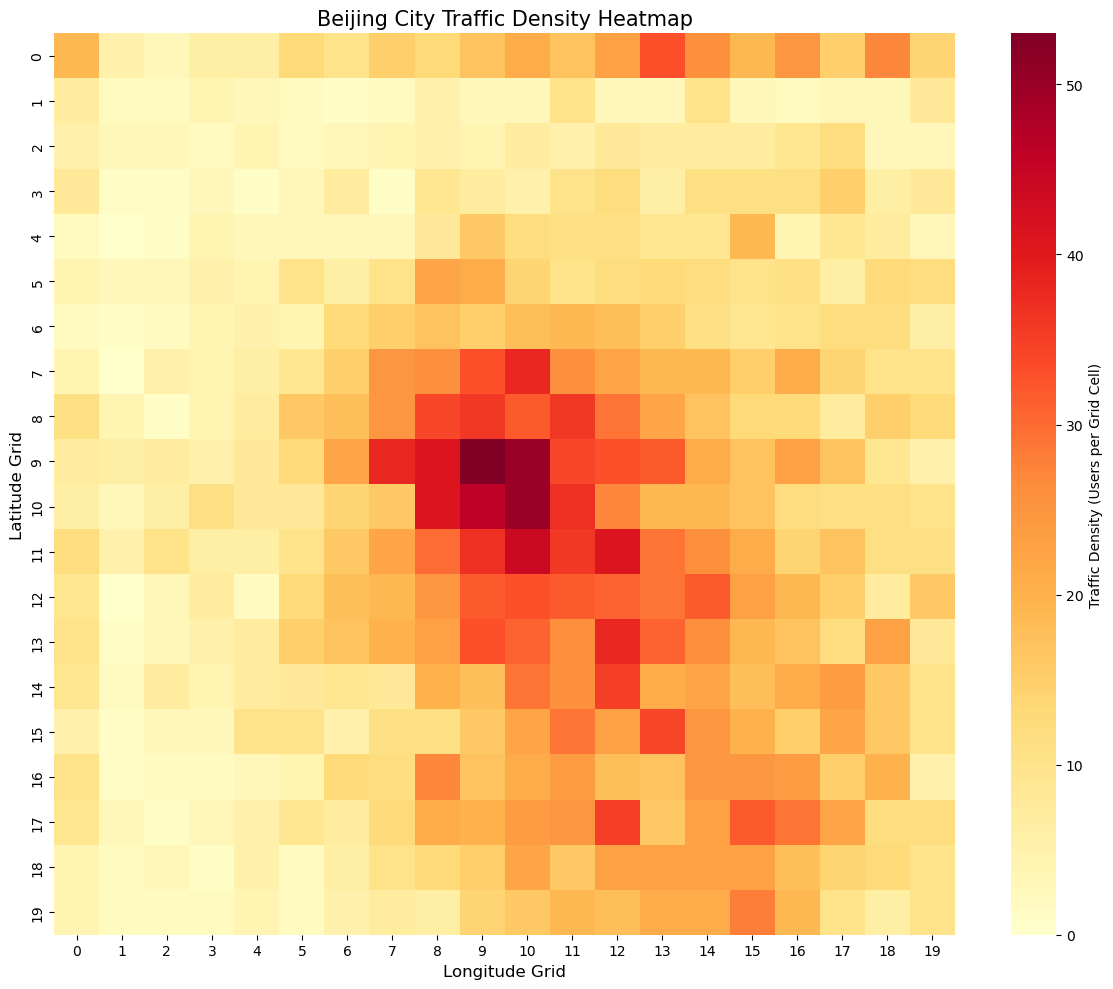

improvement(under construction)

In [20]:
def main():
    # Load and preprocess data
    df = pd.read_csv('updated_dataset.csv')
    
    # Print basic dataset info
    print("Dataset shape:", df.shape)
    print("Columns:", df.columns)
    
    # Encode user_id as categorical
    user_encoder = LabelEncoder()
    df['user_id_encoded'] = user_encoder.fit_transform(df['user_id'])
    num_users = len(user_encoder.classes_)
    
    print("Number of unique users:", num_users)
    
    # Extract features and labels
    x_data_features = df[['lat', 'long', 'time', 'day_of_the_week']].values
    x_data_users = df['user_id_encoded'].values
    y_data = df[['row', 'col']].values
    
    # Normalize features
    scaler_x_features = MinMaxScaler()
    x_data_features = scaler_x_features.fit_transform(x_data_features)
    
    scaler_y = MinMaxScaler()
    y_data = scaler_y.fit_transform(y_data)
    
    # Reshape data for LSTM
    timesteps = 10
    num_features = x_data_features.shape[1]
    x_reshaped_features = []
    x_reshaped_users = []
    y_reshaped = []
    
    for i in range(len(x_data_features) - timesteps):
        x_reshaped_features.append(x_data_features[i:i + timesteps])
        x_reshaped_users.append(x_data_users[i + timesteps])
        y_reshaped.append(y_data[i + timesteps])
    
    x_reshaped_features = np.array(x_reshaped_features)
    x_reshaped_users = np.array(x_reshaped_users)
    y_reshaped = np.array(y_reshaped)
    
    # Print shapes
    print("Reshaped features shape:", x_reshaped_features.shape)
    print("Reshaped users shape:", x_reshaped_users.shape)
    print("Reshaped labels shape:", y_reshaped.shape)
    
    # Split data
    x_train_features, x_test_features, x_train_users, x_test_users, y_train, y_test = train_test_split(
        x_reshaped_features, x_reshaped_users, y_reshaped, test_size=0.3, random_state=42
    )
    
    # Create model with user embedding
    model = create_lstm_model(timesteps, num_features, num_users)
    
    # Print model summary
    model.summary()
    
    # Fit model with both feature and user inputs
    history = model.fit(
        [x_train_features, x_train_users], y_train,
        epochs=5,  # Reduced epochs for quick testing
        batch_size=32,
        validation_data=([x_test_features, x_test_users], y_test),
        verbose=1
    )
    
    # Print training history
    print("Training History:")
    print(history.history)
    
    # Simplified evaluation
    test_loss, test_mae = model.evaluate([x_test_features, x_test_users], y_test)
    print(f"Test Loss: {test_loss}")
    print(f"Test MAE: {test_mae}")

In [4]:
import numpy as np
import matplotlib.pyplot as plt

def generate_hetnet_load_data(duration_mins=60, num_bs_types=3):
    """
    Generate realistic load data for HetNet Base Stations
    
    Args:
    - duration_mins: Total simulation time in minutes
    - num_bs_types: Number of base station types (Macro, Micro, Pico)
    
    Returns:
    - time_points: Array of time points
    - load_before: Load data before load balancing
    - load_after: Load data after load balancing
    """
    # Create time points
    time_points = np.linspace(0, duration_mins, 100)
    
    # Base station characteristics
    bs_types = ['Macro BS', 'Micro BS', 'Pico BS']
    base_loads = [70, 50, 30]  # Initial typical load percentages
    
    # Before Load Balancing - Uneven Distribution
    load_before = []
    for base_load in base_loads:
        # Create a smooth load curve with some variations
        load_curve = base_load + 10 * np.sin(time_points/10) + np.random.normal(0, 3, len(time_points))
        load_curve = np.clip(load_curve, 20, 90)  # Realistic load range
        load_before.append(load_curve)
    
    # After Load Balancing - More Balanced Distribution
    load_after = []
    for base_load in base_loads:
        # Smoother, more balanced load distribution
        load_curve = base_load + 5 * np.sin(time_points/20) + np.random.normal(0, 2, len(time_points))
        load_curve = np.clip(load_curve, 40, 60)  # Tighter, more balanced range
        load_after.append(load_curve)
    
    return time_points, load_before, load_after

def plot_hetnet_load_balancing():
    """
    Create a comparative plot of HetNet base station loads
    """
    try:
        # Generate data
        time_points, load_before, load_after = generate_hetnet_load_data()
        
        # Set up the plot
        plt.figure(figsize=(15, 6))
        
        # Before Load Balancing
        plt.subplot(1, 2, 1)
        bs_types = ['Macro BS', 'Micro BS', 'Pico BS']
        colors = ['red', 'green', 'blue']
        
        for i, (load, bs_type, color) in enumerate(zip(load_before, bs_types, colors)):
            plt.plot(time_points, load, label=bs_type, color=color, linewidth=2)
        
        plt.title('Load Distribution Before Load Balancing', fontsize=12)
        plt.xlabel('Time (mins)', fontsize=10)
        plt.ylabel('Load (%)', fontsize=10)
        plt.ylim(0, 100)
        plt.legend()
        plt.grid(True, linestyle='--', alpha=0.7)
        
        # After Load Balancing
        plt.subplot(1, 2, 2)
        for i, (load, bs_type, color) in enumerate(zip(load_after, bs_types, colors)):
            plt.plot(time_points, load, label=bs_type, color=color, linewidth=2)
        
        plt.title('Load Distribution After Load Balancing', fontsize=12)
        plt.xlabel('Time (mins)', fontsize=10)
        plt.ylabel('Load (%)', fontsize=10)
        plt.ylim(0, 100)
        plt.legend()
        plt.grid(True, linestyle='--', alpha=0.7)
        
        plt.tight_layout()
        plt.savefig('hetnet_load_balancing.png')
        print("Plot saved as hetnet_load_balancing.png")
        plt.close()
    
    except Exception as e:
        print(f"An error occurred: {e}")

def calculate_load_balance_metrics(load_data):
    """
    Calculate key load balancing metrics for HetNet
    
    Args:
    - load_data: Load percentages for different base station types
    
    Returns:
    - Dictionary of load balancing metrics
    """
    metrics = {
        'mean_load': [],
        'load_variance': [],
        'max_load_difference': 0
    }
    
    for bs_loads in load_data:
        metrics['mean_load'].append(np.mean(bs_loads))
        metrics['load_variance'].append(np.var(bs_loads))
    
    metrics['max_load_difference'] = max(metrics['mean_load']) - min(metrics['mean_load'])
    
    return metrics

# Run the plot generation
plot_hetnet_load_balancing()

# Calculate and print metrics
time_points, load_before, load_after = generate_hetnet_load_data()
print("\nBefore Load Balancing Metrics:")
before_metrics = calculate_load_balance_metrics(load_before)
for key, value in before_metrics.items():
    print(f"{key}: {value}")

print("\nAfter Load Balancing Metrics:")
after_metrics = calculate_load_balance_metrics(load_after)
for key, value in after_metrics.items():
    print(f"{key}: {value}")

Plot saved as hetnet_load_balancing.png

Before Load Balancing Metrics:
mean_load: [69.81043447638521, 50.09695708943873, 30.804882957214915]
load_variance: [51.655895171534084, 63.049944493949944, 54.260146237723255]
max_load_difference: 39.0055515191703

After Load Balancing Metrics:
mean_load: [60.0, 53.26638280173633, 40.0]
load_variance: [0.0, 5.47649405635114, 0.0]
max_load_difference: 20.0
